In [1]:
# Loading libraries
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Input,Dense, Conv2DTranspose, MaxPooling2D, UpSampling2D, Concatenate, Conv2D,ReLU 
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import time
import cv2

In [2]:
# Loading MNIST data
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Splitting the training data into training and validation sets

train_images, validation_images, train_labels, validation_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)


# PART 1

### Step 1: GENERATING LOW RES IMAGES USING GAUSSIAN BLUR

In [3]:
# Function for creating low resolution images 
def low_resolution_images(images, scale_factor, blur_kernel_size, sigmaX):
    
    low_resolution_images = []

    for image in images:
        # Applying Gaussian blur
        blurred_image = cv2.GaussianBlur(image, blur_kernel_size, sigmaX=sigmaX)

        # Ensuring the blurred image is resized to (28, 28)
        low_resolution_image = cv2.resize(blurred_image, (28, 28))

        # Adding a channel dimension to make it 3-dimensional
        low_resolution_image = np.expand_dims(low_resolution_image, axis=-1)

        low_resolution_images.append(low_resolution_image)

    return np.array(low_resolution_images)
    

# Creating the images
scale_factor = 10
blur_kernel_size = (9,9)
sigmaX = 1.5
train_low_resolution_images = low_resolution_images(train_images,scale_factor, blur_kernel_size,sigmaX)
test_low_resolution_images = low_resolution_images(test_images,scale_factor, blur_kernel_size,sigmaX)

In [4]:
# Normalize pixel values to the range [0, 1]
train_low_resolution_images = train_low_resolution_images.astype('float32') / 255.0
test_low_resolution_images = test_low_resolution_images.astype('float32') / 255.0
train_images = train_images.astype('float32') / 255.0
validation_images = validation_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

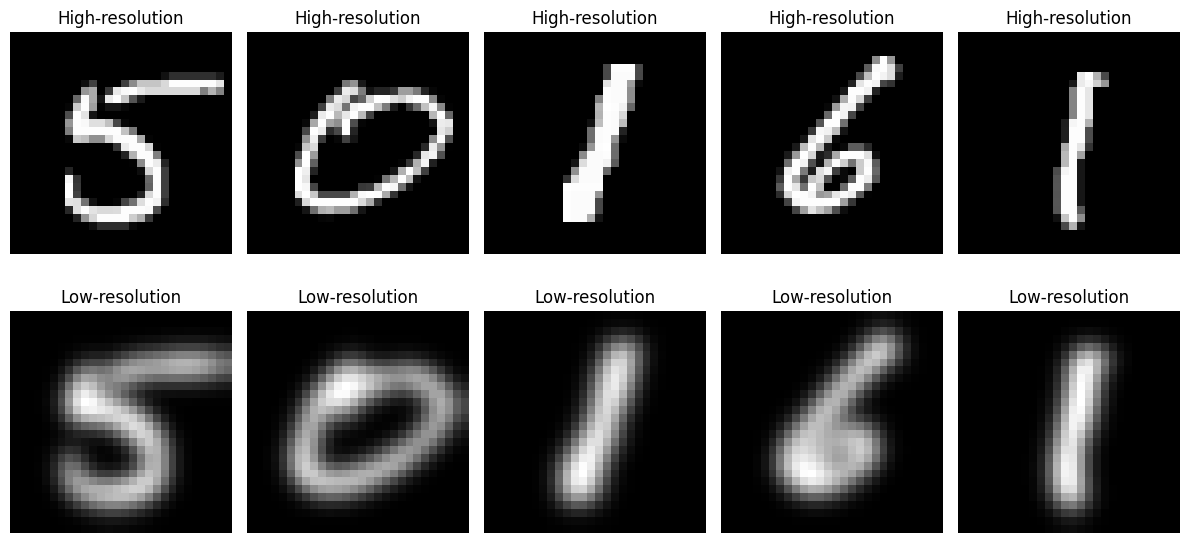

In [5]:
# Visualizing a few samples of high-resolution and low-resolution images
samples = 5
plt.figure(figsize=(12, 6))
for i in range(samples):
    plt.subplot(2, samples, i + 1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title('High-resolution')
    plt.axis('off')
    
    plt.subplot(2, samples, i + samples + 1)
    plt.imshow(train_low_resolution_images[i, :, :, 0], cmap='gray') 
    plt.title('Low-resolution')
    plt.axis('off')

plt.tight_layout()
plt.savefig('high_low_res_display.png')
plt.show()

### STEP 2: DESIGN U-NET BASED ARCHITECTURE

In [6]:
# Defining the superresolution unet model

def res_unet_model(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder layer 
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Middle layer
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)

    # Decoder Layer
    up1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv2)
    concat1 = Concatenate()([conv1, up1])
    conv3 = Conv2D(64, 3, activation='relu', padding='same')(concat1)
    conv3 = Conv2D(64, 3, activation='relu', padding='same')(conv3)

    # Output Layer
    outputs = Conv2D(1, 3, activation='sigmoid', padding='same')(conv3)

    model = Model(inputs, outputs)
    return model

# Creating the model
input_shape = (28, 28, 1)
res_unet_model = res_unet_model(input_shape)

# Printing the model summary
res_unet_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 64)           640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 28, 28, 64)           36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

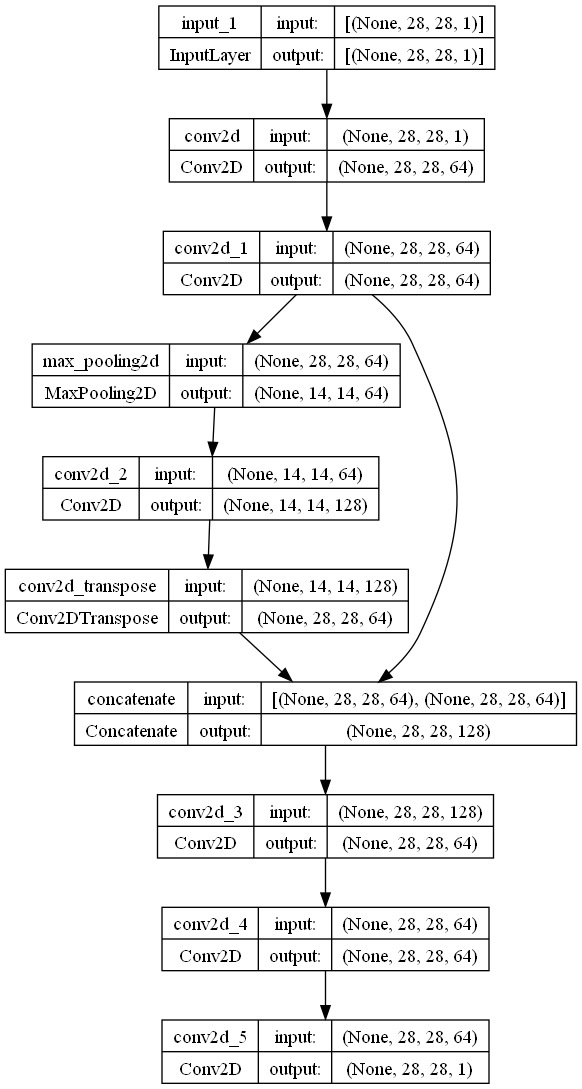

In [7]:
# Visualizing the model
plot_model(res_unet_model, show_shapes=True, to_file='res_unet_model.png')

### STEP 3: TRAIN THE MODEL AND PLOT

In [8]:
# Compiling the model with binary cross-entropy loss
res_unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
# Defining the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

start_time = time.time()
# Training the model
res_unet_history = res_unet_model.fit(train_low_resolution_images, train_images, epochs=10, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

# End the timer
end_time = time.time()

Epoch 1/10
2400/2400 [==============================] - 216s 90ms/step - loss: 0.0668 - accuracy: 0.8148 - val_loss: 0.0619 - val_accuracy: 0.8169
Epoch 2/10
2400/2400 [==============================] - 214s 89ms/step - loss: 0.0619 - accuracy: 0.8151 - val_loss: 0.0614 - val_accuracy: 0.8169
Epoch 3/10
2400/2400 [==============================] - 212s 88ms/step - loss: 0.0616 - accuracy: 0.8151 - val_loss: 0.0610 - val_accuracy: 0.8169
Epoch 4/10
2400/2400 [==============================] - 213s 89ms/step - loss: 0.0614 - accuracy: 0.8151 - val_loss: 0.0610 - val_accuracy: 0.8169
Epoch 5/10
2400/2400 [==============================] - 213s 89ms/step - loss: 0.0613 - accuracy: 0.8151 - val_loss: 0.0609 - val_accuracy: 0.8169
Epoch 6/10
2400/2400 [==============================] - 211s 88ms/step - loss: 0.0612 - accuracy: 0.8151 - val_loss: 0.0607 - val_accuracy: 0.8169
Epoch 7/10
2400/2400 [==============================] - 212s 88ms/step - loss: 0.0611 - accuracy: 0.8151 - val_loss: 0

In [10]:
# Calculating the elapsed time
elapsed_time = end_time - start_time

# Printing the elapsed time in seconds
print(f"Training took {elapsed_time} seconds for the Res Model without classification")

Training took 2125.6075735092163 seconds for the Res Model without classification


In [11]:
# Evaluating the model
test_loss, test_accuracy = res_unet_model.evaluate(test_low_resolution_images, test_images, verbose=2)
print("\nTest accuracy:", test_accuracy)

313/313 - 10s - loss: 0.0605 - accuracy: 0.8145 - 10s/epoch - 31ms/step

Test accuracy: 0.8144914507865906


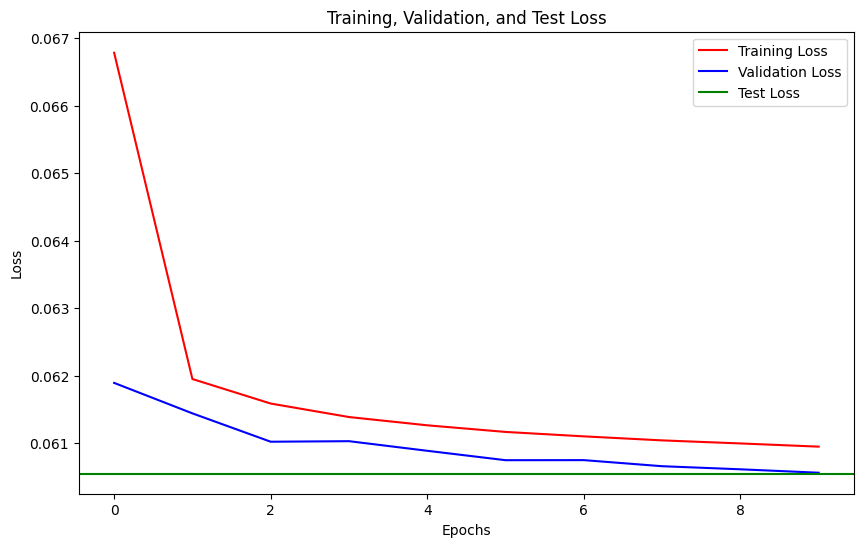

In [12]:
# Plotting the training, validation, and test losses
plt.figure(figsize=(10, 6))
plt.plot(res_unet_history.history['loss'], label='Training Loss', color = 'red')
plt.plot(res_unet_history.history['val_loss'], label='Validation Loss', color = 'blue')
plt.axhline(y=test_loss, color='green', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training, Validation, and Test Loss for Res Model Without Classification')
plt.legend()
plt.savefig('loss_for_res_without_classification.png')
plt.show()

1/1 [==============================] - 0s 107ms/step


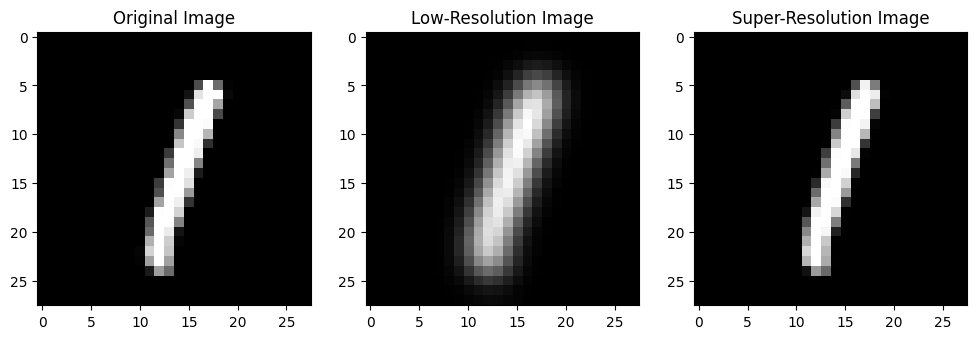

In [13]:
# Performing super-resolution on a sample image from the test dataset
index = 5
low_res_image = test_low_resolution_images[index]
super_res_image = res_unet_model.predict(np.expand_dims(low_res_image, axis=0))[0]

# Visualizing the original, low-res, and super-res images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(test_images[index], cmap='gray')
plt.subplot(1, 3, 2)
plt.title("Low-Resolution Image")
plt.imshow(low_res_image.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title("Super-Resolution Image for Model without classification")
plt.imshow(super_res_image.squeeze(), cmap='gray')
plt.savefig('test_visualization_for_model_without_classification.png')
plt.show()

# PART 2

### STEP 1 : CLASSIFICATION MODEL

In [14]:
# RES MODEL WITH CLASSIFICATION

def res_unet_with_classification(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Encoder layer
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    # Middle layer
    bottleneck = Conv2D(128, 3, activation='relu', padding='same')(pool1)

    # Flatten the bottleneck layer
    flatten = Flatten()(bottleneck)

    # Fully connected layers for classification
    fc1 = Dense(128, activation='relu')(flatten)
    fc2 = Dense(num_classes, activation='softmax')(fc1)  

    # Decoder Layer
    up1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bottleneck)
    concat1 = Concatenate()([conv1, up1])
    conv3 = Conv2D(64, 3, activation='relu', padding='same')(concat1)
    conv3 = Conv2D(64, 3, activation='relu', padding='same')(conv3)

    # Output Layer for reconstruction and classification 
    reconstruction_output = Conv2D(1, 3, activation='sigmoid', padding='same', name='reconstruction_output')(conv3)
    classification_output = Dense(num_classes, activation='softmax', name='classification_output')(fc2)
    
    model = Model(inputs, [ reconstruction_output, classification_output])
    
    return model

# Creating the model with classification
num_classes = 10
input_shape = (28, 28, 1)
res_unet_with_classification_model = res_unet_with_classification(input_shape, num_classes)

# Printing the model summary
res_unet_with_classification_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 28, 28, 64)           640       ['input_2[0][0]']             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 28, 28, 64)           36928     ['conv2d_6[0][0]']            
                                                                                                  
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)           0         ['conv2d_7[0][0]']            
 g2D)                                                                                       

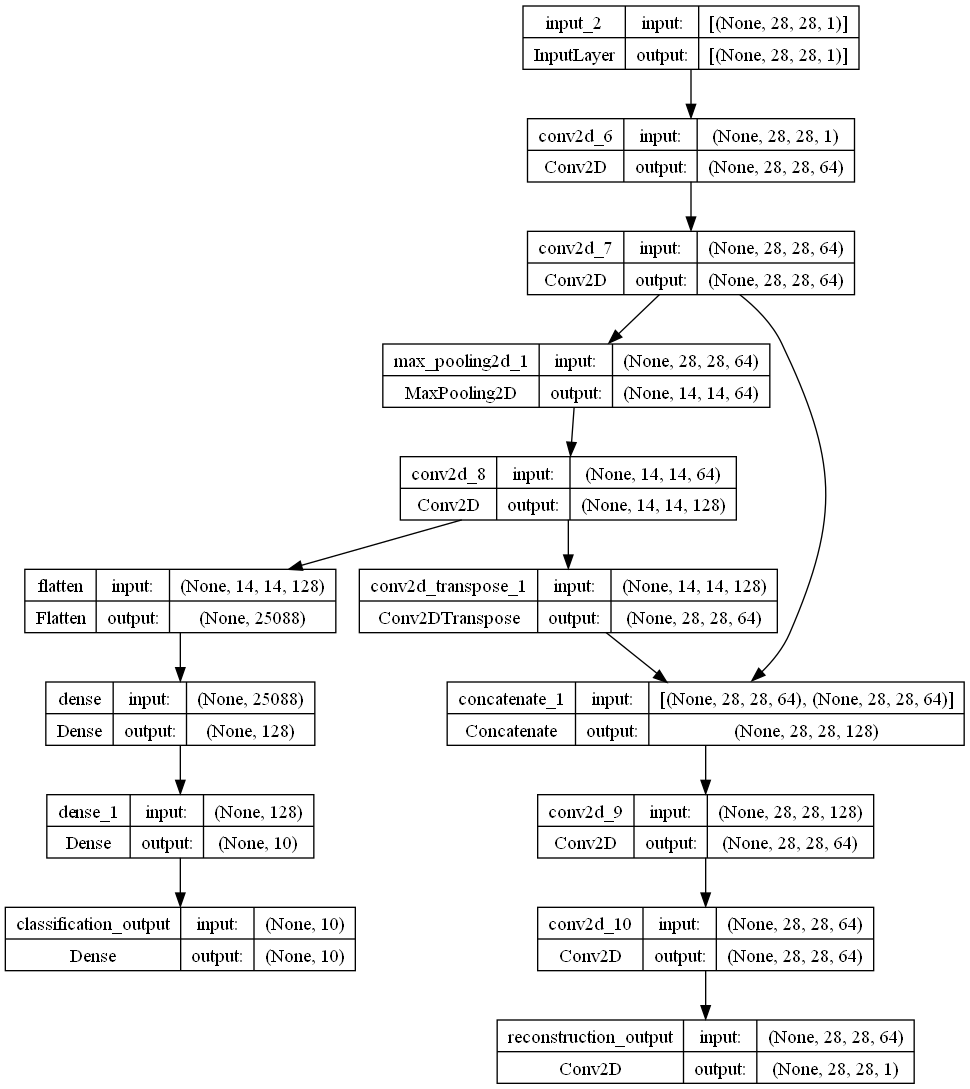

In [15]:
# Visualizing the model
plot_model(res_unet_with_classification_model, show_shapes=True, to_file='res_unet_with_classification_model.png')

### STEP 2: TRAIN THE MODEL

In [16]:
## Converting labels to one hot
train_labels_onehot = to_categorical(train_labels)
test_labels_onehot = to_categorical(test_labels)
validation_labels_onehot = to_categorical(validation_labels)

In [17]:
print("Training Low-Resolution Images Shape:", train_low_resolution_images.shape)
print("Testing Low-Resolution Images Shape:", test_low_resolution_images.shape)
print("Validation Images Shape:", validation_images.shape)
print("Training  Images Shape:", train_images.shape)
print("Train Labels:", train_labels_onehot.shape)
print("Test Labels:", test_labels_onehot.shape)
print("Testing Images Shape:", test_images.shape)

Training Low-Resolution Images Shape: (48000, 28, 28, 1)
Testing Low-Resolution Images Shape: (10000, 28, 28, 1)
Validation Images Shape: (12000, 28, 28)
Training  Images Shape: (48000, 28, 28)
Train Labels: (48000, 10)
Test Labels: (10000, 10)
Testing Images Shape: (10000, 28, 28)


In [18]:
# Defining the loss functions

loss_functions = {
    "reconstruction_output": binary_crossentropy,
    "classification_output": categorical_crossentropy
}


In [19]:
# Compiling the model with two loss functions
res_unet_with_classification_model.compile(optimizer='adam', loss=loss_functions, metrics=['accuracy'])

# Start the timer
start_time = time.time()

# Train the model
reclassification_history = res_unet_with_classification_model.fit(train_images, {"reconstruction_output": train_images, "classification_output": train_labels_onehot},
                    validation_split = 0.2,
                    epochs=10, 
                    batch_size=16, 
                    verbose=1, 
                    callbacks=[early_stopping])

# End the timer
end_time = time.time()

Epoch 1/10
2400/2400 [==============================] - 259s 107ms/step - loss: 1.3499 - reconstruction_output_loss: 0.0637 - classification_output_loss: 1.2862 - reconstruction_output_accuracy: 0.8150 - classification_output_accuracy: 0.6332 - val_loss: 0.9818 - val_reconstruction_output_loss: 0.0598 - val_classification_output_loss: 0.9220 - val_reconstruction_output_accuracy: 0.8169 - val_classification_output_accuracy: 0.6432
Epoch 2/10
2400/2400 [==============================] - 258s 107ms/step - loss: 0.8898 - reconstruction_output_loss: 0.0599 - classification_output_loss: 0.8299 - reconstruction_output_accuracy: 0.8151 - classification_output_accuracy: 0.6661 - val_loss: 0.8986 - val_reconstruction_output_loss: 0.0595 - val_classification_output_loss: 0.8391 - val_reconstruction_output_accuracy: 0.8169 - val_classification_output_accuracy: 0.6645
Epoch 3/10
2400/2400 [==============================] - 257s 107ms/step - loss: 0.8746 - reconstruction_output_loss: 0.0597 - classi

In [20]:
# Calculating the elapsed time
elapsed_time = end_time - start_time

# Printing the elapsed time in seconds
print(f"Training took {elapsed_time} seconds for the Res Model without classification")

Training took 1552.2776129245758 seconds for the Res Model without classification


In [21]:
# Evaluating the model on the test dataset
test_losses = res_unet_with_classification_model.evaluate(test_images, {"reconstruction_output": test_images, "classification_output": test_labels_onehot})

# Printing individual loss values and metrics
for i, output_name in enumerate(res_unet_with_classification_model.output_names):
    print(f"Test {output_name} Loss: {test_losses[i]:.4f}")

classification_accuracy_index = res_unet_with_classification_model.metrics_names.index("classification_output_accuracy")
reconstruction_accuracy_index = res_unet_with_classification_model.metrics_names.index("reconstruction_output_accuracy")

classification_accuracy = test_losses[classification_accuracy_index]
reconstruction_accuracy = test_losses[reconstruction_accuracy_index]

print(f"Test Classification Accuracy: {classification_accuracy * 100:.2f}%")
print(f"Test Reconstruction Accuracy: {reconstruction_accuracy * 100:.2f}%")

313/313 [==============================] - 10s 31ms/step - loss: 0.8042 - reconstruction_output_loss: 0.0593 - classification_output_loss: 0.7448 - reconstruction_output_accuracy: 0.8145 - classification_output_accuracy: 0.6793
Test reconstruction_output Loss: 0.8042
Test classification_output Loss: 0.0593
Test Classification Accuracy: 67.93%
Test Reconstruction Accuracy: 81.45%


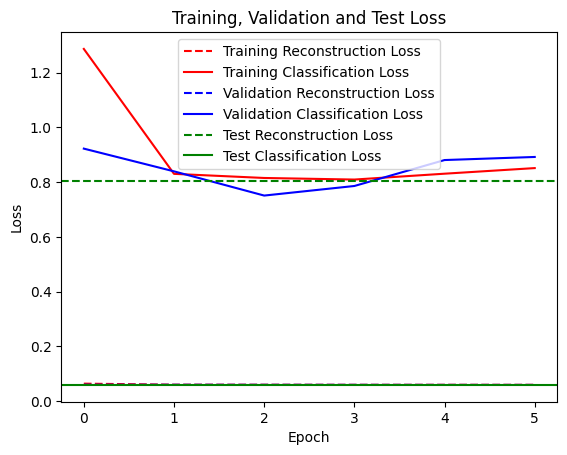

In [22]:

# Plot training loss
plt.plot(reclassification_history.history['reconstruction_output_loss'], linestyle='--', color='red', label='Training Reconstruction Loss')
plt.plot(reclassification_history.history['classification_output_loss'], color='red', label='Training Classification Loss')

# Plot validation loss
plt.plot(reclassification_history.history['val_reconstruction_output_loss'], linestyle='--', color='blue', label='Validation Reconstruction Loss')
plt.plot(reclassification_history.history['val_classification_output_loss'], color='blue', label='Validation Classification Loss')

# Plot the test loss
plt.axhline(y=test_losses[0], color='g', linestyle='--', label='Test Reconstruction Loss')
plt.axhline(y=test_losses[1], color='g', label='Test Classification Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training, Validation and Test Loss')
plt.savefig('loss_for_res_with_classification.png')
plt.show()


1/1 [==============================] - 0s 85ms/step


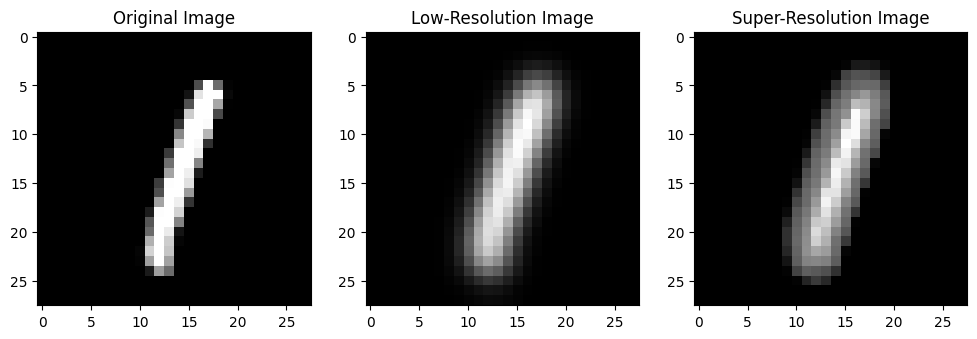

In [23]:
# Performing super-resolution with classification on a sample image from the test dataset
index = 5
low_res_image = test_low_resolution_images[index]
super_res_image = res_unet_with_classification_model.predict(np.expand_dims(low_res_image, axis=0))[0]

# Visualizing the original, low-res, and super-res images
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(test_images[index], cmap='gray')
plt.subplot(1, 3, 2)
plt.title("Low-Resolution Image")
plt.imshow(low_res_image.squeeze(), cmap='gray')
plt.subplot(1, 3, 3)
plt.title("Super-Resolution Image")
plt.imshow(super_res_image.squeeze(), cmap='gray')
plt.savefig('test_visualization_for_model_with_classification.png')
plt.show()

1/1 [==============================] - 0s 16ms/step


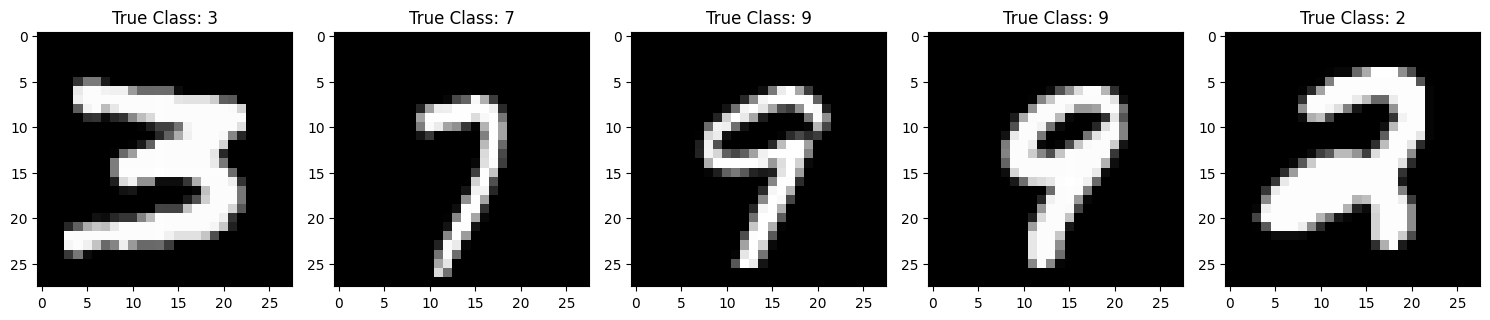

In [25]:
# Defining a function to visualize classification results for a sample of images
def visualize_classification_results(images, true_labels, model, num_samples=5):
    plt.figure(figsize=(15, 5))
    
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"True Class: {true_labels[i]}")

        # Expand dimensions for prediction
        image = images[i].reshape(1, 28, 28, 1)

        # Predict the classification probabilities for the sample image
        classification_probs = model.predict(image)[1]

    plt.tight_layout()
    plt.savefig('test_visualization_for_classification_task.png')
    plt.show()

# Choosing a sample of 5 images and corresponding true labels and running function
size = 5
indices = np.random.choice(len(test_images), size, replace=False)
images = test_images[indices]
true_labels = test_labels[indices]

# Visualize classification results for the sample images
visualize_classification_results(images, true_labels, res_unet_with_classification_model, num_samples=size)

